In [7]:
import numpy as np
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance
from UncertaintyPropagation import (UncertaintyPropagationApprox,
                                    UncertaintyPropagationExact,
                                    UncertaintyPropagationMC, 
                                    UncertaintyPropagationNumericalHG)
from InverseUncertaintyPropagation import InverseUncertaintyPropagationApprox


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


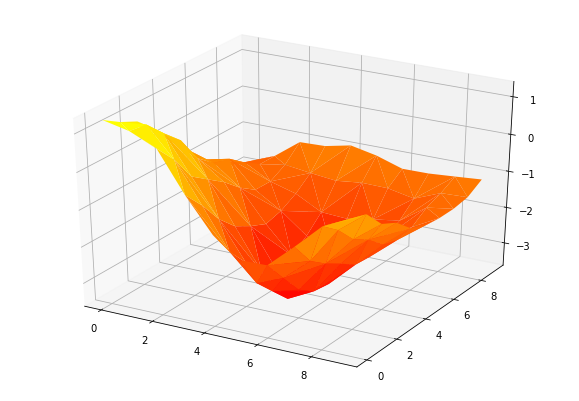

In [23]:
# Preparing some parameters (just to create the example data)
seed = 1
x = np.array([[x1,x2] for x1 in range(10) for x2 in range(10)]) # 2d sim input (no need to be a neat grid in practice)
w = np.array([0.1,0.04])   # GP bandwidth parameter
v = 2                       # GP variance parameter
vt = 0.01                   # GP variance of the error epsilon

# Preparing the parameter vector
theta = np.zeros(2+len(w))
theta[0] = np.log(v)  # We actually use the log of the parameters as it is easier to optimize (no > 0 constraint etc.)
theta[1] = np.log(vt)
theta[2:2+len(w)] = np.log(w)

# Simulating simulation data by drawing data from a random Gaussian process
t = GaussianProcess.get_realisation(x, GaussianCovariance(),theta, random_state=seed)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
# ax.plot_trisurf(x_new.T[0],x_new.T[1],means, cmap=cm.winter, linewidth=0.2)
plt.show()

### Standard GP Regression

In [24]:
# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x, t,GaussianCovariance());

[ 0.16791016 -1.2183842  -3.00815479 -3.00815479]
l_bfgs_b 	 1.6217124462127686 	 -56.95298897222113 	 [ 0.80608659 -5.03436619 -2.18634153 -3.23381691]
[ 0.80608659 -5.03436619 -2.18634153 -3.23381691]


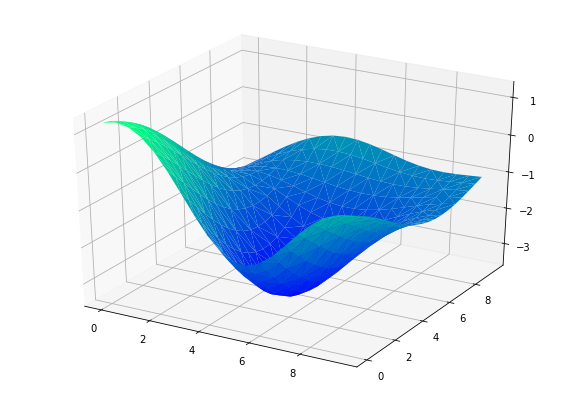

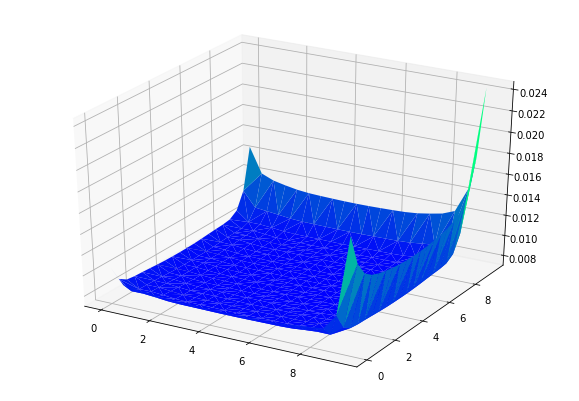

In [28]:
# Getting some values from the regression GP for plotting
x_new = np.array([[x1/2.0,x2/2.0] for x1 in range(20) for x2 in range(20)])
means, variances = gp_est.estimate_many(x_new)

# Plotting the output

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1],means, cmap=cm.winter, linewidth=0.2)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1],variances, cmap=cm.winter, linewidth=0.2)
plt.show()

### Uncertainty Propagation: Approximate

In [29]:
#####################################
# Approximate
#####################################

# Continuing the regression example


# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationApprox(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

-3.354530183682452 0.0009356995327795617


In [30]:
%timeit up.propagate_GA(mean,Sigma)

94.5 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(400,) (400,)


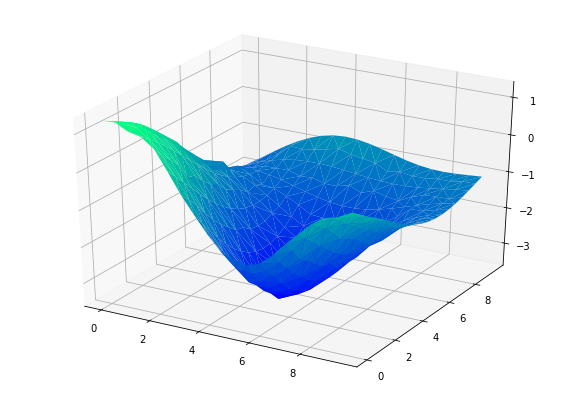

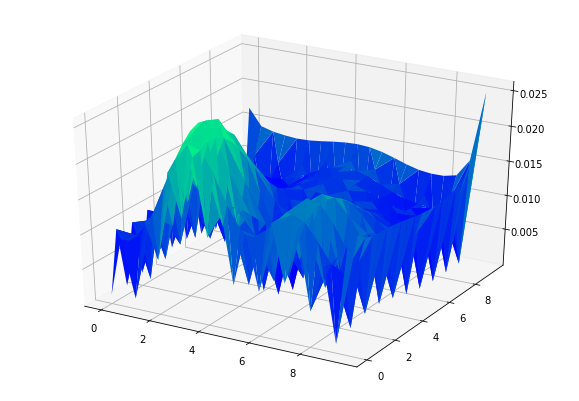

CPU times: user 2min 14s, sys: 14min 42s, total: 16min 57s
Wall time: 41.2 s


In [41]:
%%time
#The propagation step

up = UncertaintyPropagationApprox(gp_est)


# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_new)
out_mean = np.zeros(n_samples)
out_variance = np.zeros(n_samples)

for i in range(n_samples):

    out_mean[i], out_variance[i] = up.propagate_GA(x_new[i],Sigma)

print(out_mean.shape, out_variance.shape)

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_mean, cmap=cm.winter, linewidth=0.2)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_variance, cmap=cm.winter, linewidth=0.2)
plt.show()

### Uncertainty Propagation (Exact)

In [32]:
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationExact(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

-3.3545267858801724 0.0009585210954554668


In [33]:
%timeit up.propagate_GA(mean,Sigma)

97.8 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


(400,) (400,)


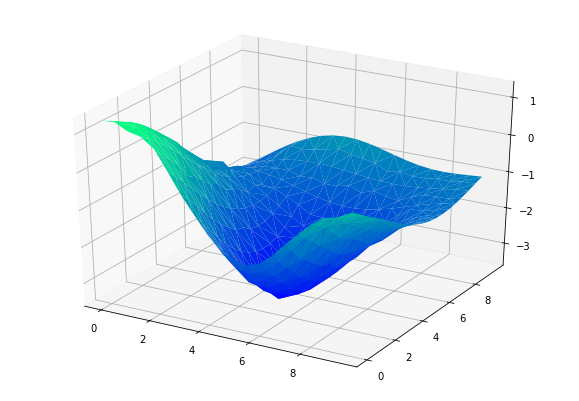

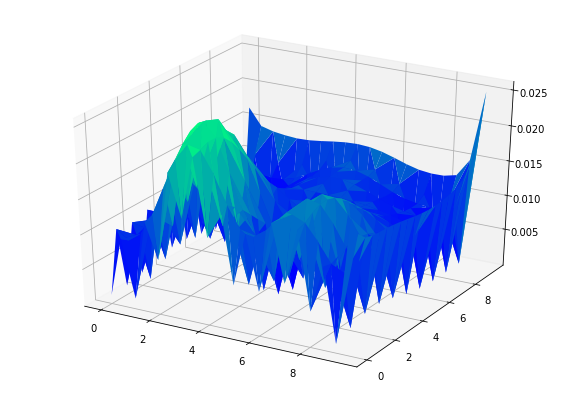

CPU times: user 2min 8s, sys: 14min 5s, total: 16min 14s
Wall time: 39.5 s


In [34]:
%%time
#The propagation step

up = UncertaintyPropagationExact(gp_est)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_new)
out_mean = np.zeros(n_samples)
out_variance = np.zeros(n_samples)

for i in range(n_samples):

    out_mean[i], out_variance[i] = up.propagate_GA(x_new[i],Sigma)

print(out_mean.shape, out_variance.shape)

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_mean, cmap=cm.winter, linewidth=0.2)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_variance, cmap=cm.winter, linewidth=0.2)
plt.show()

### Uncertainty Propagation: MonteCarlo (Integral)

In [35]:
#####################################
# MC
#####################################
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationMC(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

-3.3435866210520597 0.01356746907433859


In [36]:
%timeit up.propagate_GA(mean,Sigma)

572 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(400,) (400,)


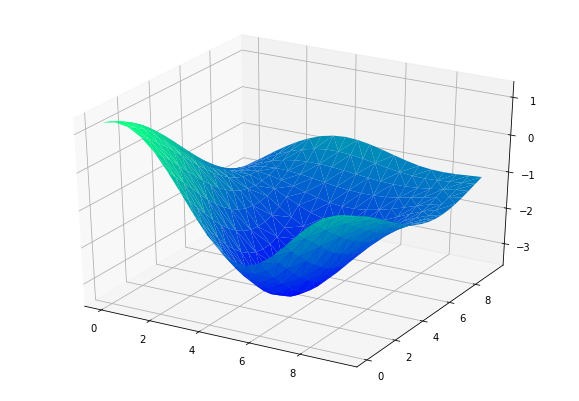

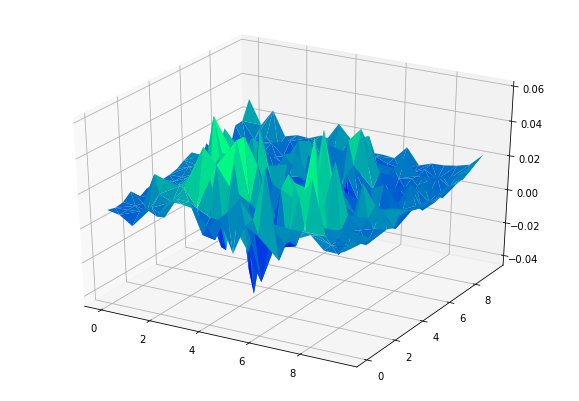

CPU times: user 13min 38s, sys: 1h 20min 20s, total: 1h 33min 58s
Wall time: 3min 46s


In [37]:
%%time
#The propagation step

up = UncertaintyPropagationMC(gp_est)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_new)
out_mean = np.zeros(n_samples)
out_variance = np.zeros(n_samples)

for i in range(n_samples):

    out_mean[i], out_variance[i] = up.propagate_GA(x_new[i],Sigma)

print(out_mean.shape, out_variance.shape)

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_mean, cmap=cm.winter, linewidth=0.2)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_variance, cmap=cm.winter, linewidth=0.2)
plt.show()

### Uncertainty Propagation: Gauss-Hermite Quadrature (Integral)

In [38]:
#####################################
# Numerical HG
#####################################
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationNumericalHG(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

-3.3434920148551712 0.00832259786474232


In [39]:
%timeit up.propagate_GA(mean,Sigma)

11.2 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(400,) (400,)


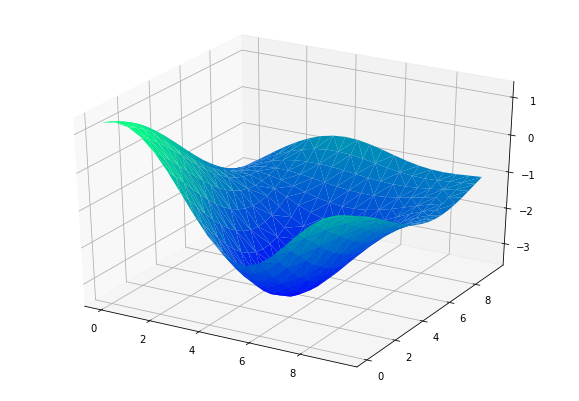

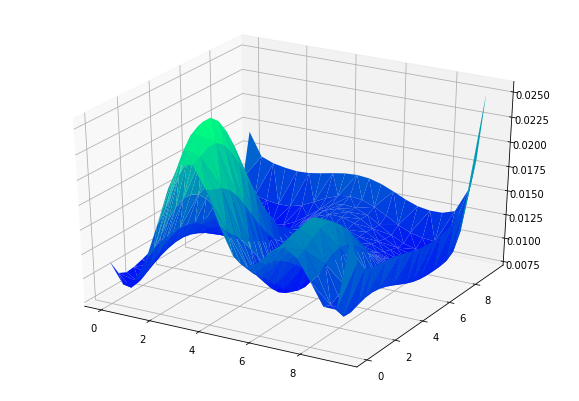

CPU times: user 16.8 s, sys: 1min 38s, total: 1min 55s
Wall time: 5.2 s


In [40]:
%%time
#The propagation step

up = UncertaintyPropagationNumericalHG(gp_est)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_new)
out_mean = np.zeros(n_samples)
out_variance = np.zeros(n_samples)

for i in range(n_samples):

    out_mean[i], out_variance[i] = up.propagate_GA(x_new[i],Sigma)

print(out_mean.shape, out_variance.shape)

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_mean, cmap=cm.winter, linewidth=0.2)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1], out_variance, cmap=cm.winter, linewidth=0.2)
plt.show()

In [46]:
# Continuing the propagation example

# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

#####################################
# Approximate
#####################################

# Continuing the regression example


# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationApprox(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x, t,GaussianCovariance());

# The fisher information matrix for the maximum likelihood estimation of x
# This assumes both components of x to be rate parameters of exponential distributions
I = np.array([1/mean[0]**2,1/mean[1]**2])

# cost vector: the cost for collecting one sample for the estimation of the components of x
c = np.ones(2) # Collecting one sample for each component of x costs 1

# The cost for collecting enough samples to approximately get the Sigma from above (Cramer-Rao-Bound)
print((c/I/np.diag(Sigma)).sum())

# The desired output variance (in this example) is out_variance
# Getting the Sigma that leads to the minimal data collection costs while still yielding out_variance
# If multiple parameters from the same distribution (and therefore the same sample) have to be estimated, we could use the optional parameter "coestimated"
iup = InverseUncertaintyPropagationApprox(out_variance,gp_est,mean,c,I)
Sigma_opt = np.diag(iup.get_best_solution())

# The optimal data collection cost to get the output variance out_variance
print('Optimal Sigma:', np.diag(Sigma_opt))
print((c/I/np.diag(Sigma_opt)).sum())

# Proof that we actually do get close to out_variance using Sigma_opt
out_mean, out_variance2 = up.propagate_GA(mean,Sigma_opt)
print(out_mean, out_variance2)

-3.354530183682452 0.0009356995327795617
[ 0.16791016 -1.2183842  -3.00815479 -3.00815479]
l_bfgs_b 	 0.7909128665924072 	 -56.95298897222113 	 [ 0.80608659 -5.03436619 -2.18634153 -3.23381691]
[ 0.80608659 -5.03436619 -2.18634153 -3.23381691]
5000.0
Optimal Sigma: [0.05106691 0.00878474]
3335.398930878855
-3.343100785930161 0.0009356995327673145


In [65]:
print(10 % 10)

0
